# Identificador de carros

## Pergunta a ser respondida:

- O computador consegue encontrar diferencas entre os carros fabricados pela GM antes de 2006 e apos 2016?

## Como fazer?

- Treinar um classificador binario conforme aulas 01 e 07 do modulo 01 do curso de Deep Learning do fastai.

## Base de origem:

- Crawler em anuncios do Mercado Livre (disponivel no arquivo carros_ml.py).

### disponibilizei a base tratada em: 

In [2]:
%matplotlib inline
import pandas as pd
from matplotlib import pyplot as plt
from IPython.core.display import display, HTML
import glob as gl

In [3]:
CSV_PATH = '../../csv/valid_dados_anuncios.csv'

IMG_PATH = '../../Imagens/carros_gm/'

PATH_FA = '../../Imagens/carros_fa/'

## Dando uma _espiada_ nos dados

In [3]:
df = pd.read_csv(CSV_PATH)
df.head()

ano                                                dcr  id_anuncio  \
0  1999            chevrolet-corsa-10-mpfi-super-wagon-16v  1028868123   
1  2017  chevrolet-cruze-sport6-lt-14-turbo-16v-igual-z...  1015998097   
2  2004   chevrolet-astra-20-mpfi-cd-8v-gasolina-2p-manual  1032486197   
3  2005  chevrolet-astra-sedan-20-comfort-multipower-4p...  1010267523   
4  2004             chevrolet-astra-sedan-20-8v-cd-4p-2004   963116286   

       marca       modelo  
0  Chevrolet        Corsa  
1  Chevrolet        Cruze  
2  Chevrolet        Astra  
3  Chevrolet  Astra Sedan  
4  Chevrolet  Astra Sedan

In [4]:
def espia_dados(dfe):
    display(dfe.head())
    dfe['ano'].hist(bins=15, figsize=(15,8))
    display(dfe.groupby('modelo').count()['marca'].sort_values(ascending=False).head())


ano                                                dcr  id_anuncio  \
0  1999            chevrolet-corsa-10-mpfi-super-wagon-16v  1028868123   
1  2017  chevrolet-cruze-sport6-lt-14-turbo-16v-igual-z...  1015998097   
2  2004   chevrolet-astra-20-mpfi-cd-8v-gasolina-2p-manual  1032486197   
3  2005  chevrolet-astra-sedan-20-comfort-multipower-4p...  1010267523   
4  2004             chevrolet-astra-sedan-20-8v-cd-4p-2004   963116286   

       marca       modelo  
0  Chevrolet        Corsa  
1  Chevrolet        Cruze  
2  Chevrolet        Astra  
3  Chevrolet  Astra Sedan  
4  Chevrolet  Astra Sedan

modelo
Onix       104
Cruze       39
Montana     30
Prisma      29
Corsa       28
Name: marca, dtype: int64

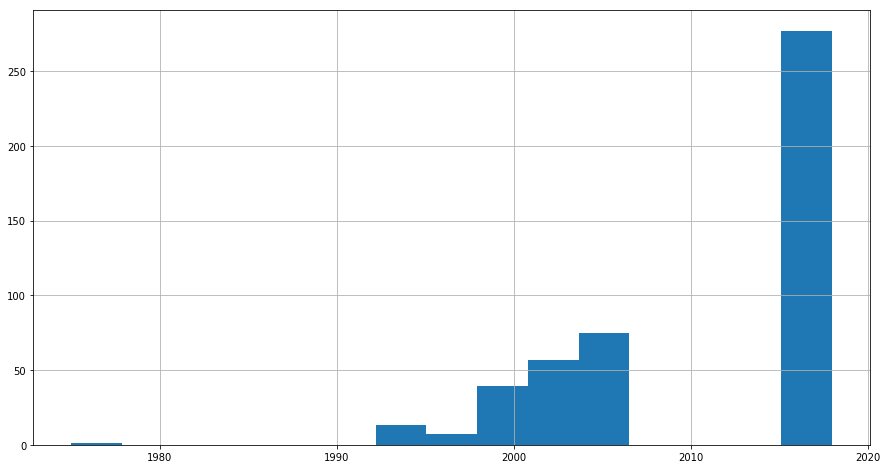

In [5]:
espia_dados(df)

In [6]:
dfm = df.copy()
#cria a target
dfm['target'] = (dfm.ano < 2010).astype(int)

In [7]:
#ha mais registros anteiores posteriores a 2016
dfm.groupby('target').count()['marca']

target
0    277
1    192
Name: marca, dtype: int64

In [8]:
#para evitar problemas vamos retirar os zero km
dfm.loc[dfm.ano < 2018].groupby('target').count()['marca']

target
0    186
1    192
Name: marca, dtype: int64

ano                                                dcr  id_anuncio  \
0  1999            chevrolet-corsa-10-mpfi-super-wagon-16v  1028868123   
1  2017  chevrolet-cruze-sport6-lt-14-turbo-16v-igual-z...  1015998097   
2  2004   chevrolet-astra-20-mpfi-cd-8v-gasolina-2p-manual  1032486197   
3  2005  chevrolet-astra-sedan-20-comfort-multipower-4p...  1010267523   
4  2004             chevrolet-astra-sedan-20-8v-cd-4p-2004   963116286   

       marca       modelo  target  
0  Chevrolet        Corsa       1  
1  Chevrolet        Cruze       0  
2  Chevrolet        Astra       1  
3  Chevrolet  Astra Sedan       1  
4  Chevrolet  Astra Sedan       1

modelo
Onix       104
Cruze       39
Montana     30
Prisma      29
Corsa       28
Name: marca, dtype: int64

3257 imagens.


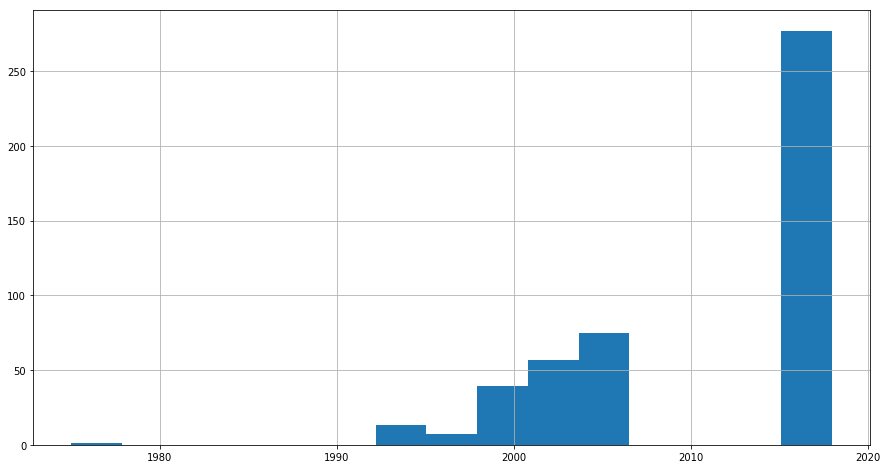

In [10]:
#dfm = dfm.loc[dfm.ano < 2018]
espia_dados(dfm)
qtd = len(gl.glob(IMG_PATH + '*/*.jpg'))
print(f'{qtd} imagens.')

## Ajustando o banco de imagens

- Copiar arquivos para o layout do fastai.
    - Somente train and valid 

In [11]:
#vamos mover as imagens para as pastas de acordo com o layout do fastai
#fazendo split dos anuncios
from sklearn.model_selection import train_test_split
from PIL import Image

X,y = [],[]
ttl_imgs = 0
for i,t in dfm[['id_anuncio','target']].itertuples(name=None,index=False):
    #necessario fazer o filtro pois algumas imagens nao foram baixadas corretamente
    ttl_imgs += len(gl.glob(f'{IMG_PATH}{str(i)}/*.jpg'))
    k = [a for a in gl.glob(f'{IMG_PATH}{str(i)}/*.jpg') if len(Image.open(a).getextrema()) == 3]
    X.extend(k)
    y.extend( [t] * len(k))
print(f'{ttl_imgs} imagens baixadas / {len(y)} imagens aproveitadas')

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

3245 imagens baixadas / 3212 imagens aproveitadas


In [12]:
X_train[:5]


['../../Imagens/carros_gm/967788655/3.jpg',
 '../../Imagens/carros_gm/1034877550/2.jpg',
 '../../Imagens/carros_gm/1020360322/5.jpg',
 '../../Imagens/carros_gm/1024457754/4.jpg',
 '../../Imagens/carros_gm/1020370738/4.jpg']

### Criação dos diretórios e movimentação dos arquivos para adaptação ao fastai

In [13]:
def cria_dirs():
    !mkdir {PATH_FA}
    !mkdir {PATH_FA}/train
    !mkdir {PATH_FA}/train/pre_06
    !mkdir {PATH_FA}/train/pos_16
    !mkdir {PATH_FA}/valid
    !mkdir {PATH_FA}/valid/pre_06
    !mkdir {PATH_FA}/valid/pos_16

cria_dirs()

In [15]:
import shutil
import os

#copiando arquivos

for arq,tg in zip(X_train,y_train):
    dd = PATH_FA + 'train/' + ('pre_06' if tg == 1 else 'pos_16') + '/' 
    a = dd + arq.split('/')[-2] + '_' + arq.split('/')[-1]
    shutil.copy(arq, a)

for arq,tg in zip(X_val,y_val):
    dd = PATH_FA + 'valid/' + ('pre_06' if tg == 1 else 'pos_16') + '/' 
    a = dd + arq.split('/')[-2] + '_' + arq.split('/')[-1]
    shutil.copy(arq, a)


## Início do Deep Learning

In [4]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.dataset import *

from fastai.model import *
from fastai.sgdr import *
from fastai.plots import *

from fastai.imports import *



In [5]:
#modelo super basico e sem tratamento de imagens, que já atingiu um resultado não desprezível.
sz = 64
arch=resnet34
data = ImageClassifierData.from_paths(PATH_FA, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.687205   0.536532   0.739726  
    1      0.594859   0.522752   0.732254                  



[array([0.52275]), 0.7322540473225405]

In [6]:
data.classes

['pos_16', 'pre_06']

In [7]:
log_preds = learn.predict()
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH_FA+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]
def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Correctly classified


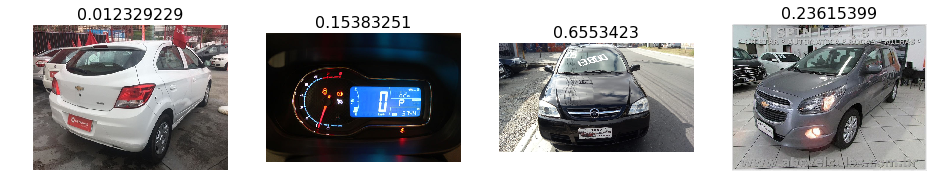

In [8]:
plot_val_with_title(rand_by_correct(True), "Correctly classified")

Incorrectly classified


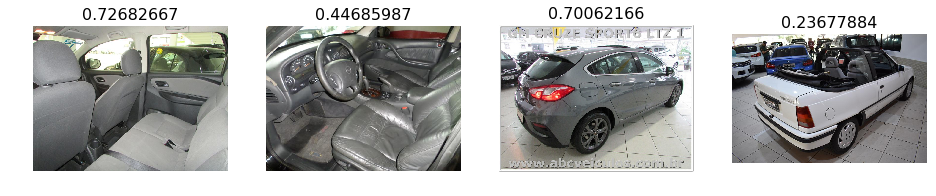

In [9]:
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

Most correct pos_16


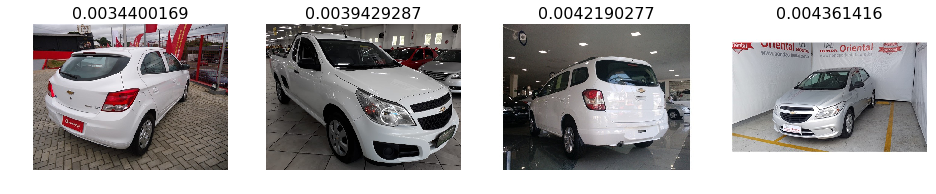

In [10]:
plot_val_with_title(most_by_correct(0, True), f"Most correct {data.classes[0]}")

Most correct pre_06


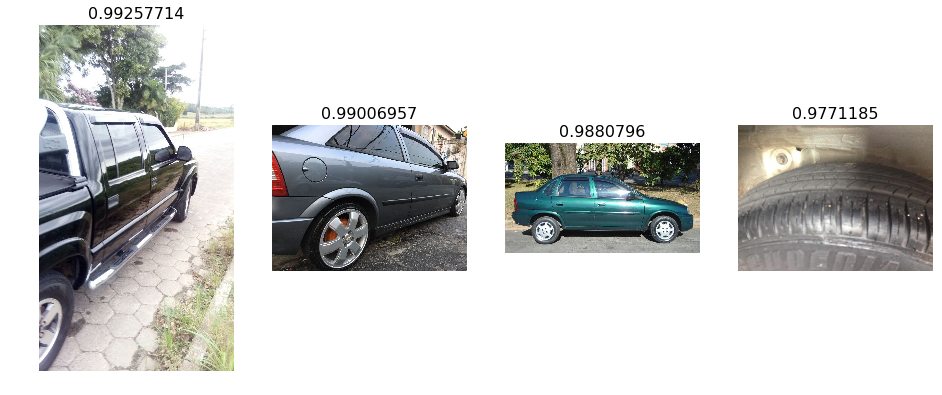

In [11]:
plot_val_with_title(most_by_correct(1, True), f"Most correct {data.classes[1]}")

Most incorrect pos_16


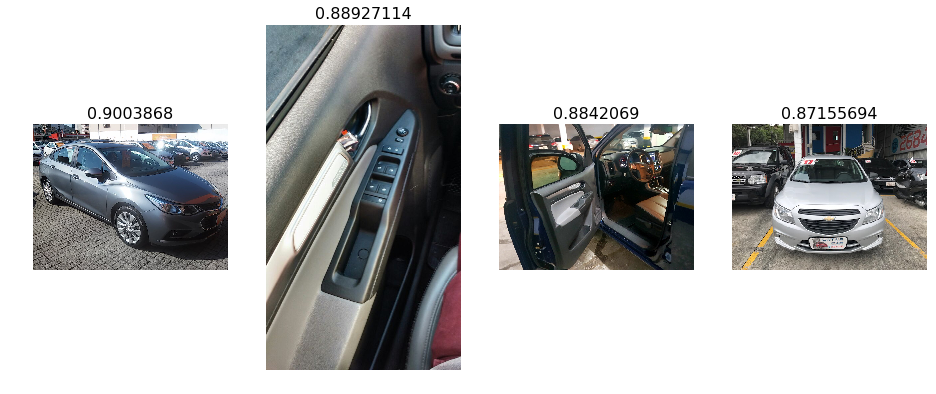

In [12]:
#Parece que estamos com dificuldade em diferenciar o interior dos carros. Esse ultimo parece um erro
plot_val_with_title(most_by_correct(0, False), f"Most incorrect {data.classes[0]}")


Most incorrect pre_06


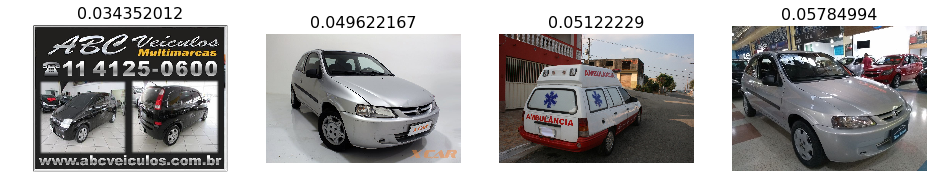

In [13]:
#Carros com o capô aberto... Esse Celta está bem estranho....
plot_val_with_title(most_by_correct(1, False), f"Most incorrect {data.classes[1]}")


Most uncertain predictions


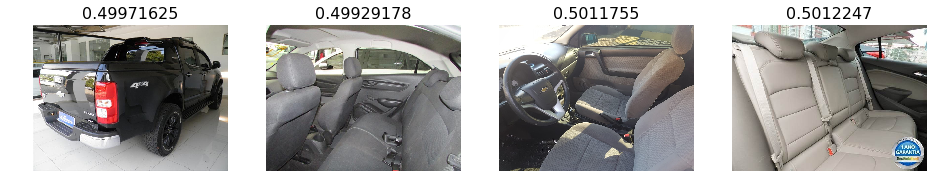

In [14]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")


## Vamos tentar uma pequena alteração

vamos tentar mexer no modelo antes de mexer no banco de imagens

In [48]:
from datetime import time
arch2 = resnet34
m = arch2(True)
bs = 64


In [50]:
#Substituindo a ultima camada (copia do exercicio da aula 7)
m = nn.Sequential(*children(m)[:-2], 
                  nn.Conv2d(512, 2, 3, padding=1), 
                  nn.AdaptiveAvgPool2d(1), Flatten(), 
                  nn.LogSoftmax())
#Tiradas as transformacoes (carro so tem uma posicao)
#Colocado zoom de 2 pois as imagens variam muito
tfms = tfms_from_model(arch, sz, max_zoom=2)
data = ImageClassifierData.from_paths(PATH_FA, tfms=tfms, bs=bs)
learn = ConvLearner.from_model_data(m, data)
learn.freeze_to(-4)
m[-1].trainable

True

In [51]:
m[-4].trainable

True

In [52]:
learn.fit(0.01, 1)

epoch      trn_loss   val_loss   accuracy                 
    0      5.672678   1.791676   0.815691  



[array([1.79168]), 0.8156911581569116]

In [53]:
#alteracao do cycle len, parece que jah deu uma mudada
learn.fit(0.01, 1, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                 
    0      1.436106   1.026847   0.84807   



[array([1.02685]), 0.8480697384806973]

### Vamos espiar antes de montar o heat map

Most correct pos_16


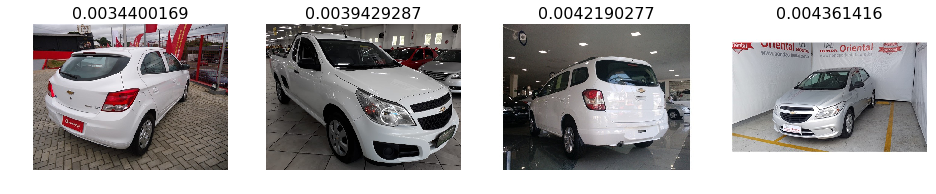

In [79]:
plot_val_with_title(most_by_correct(0, True), f"Most correct {data.classes[0]}")

Most correct pre_06


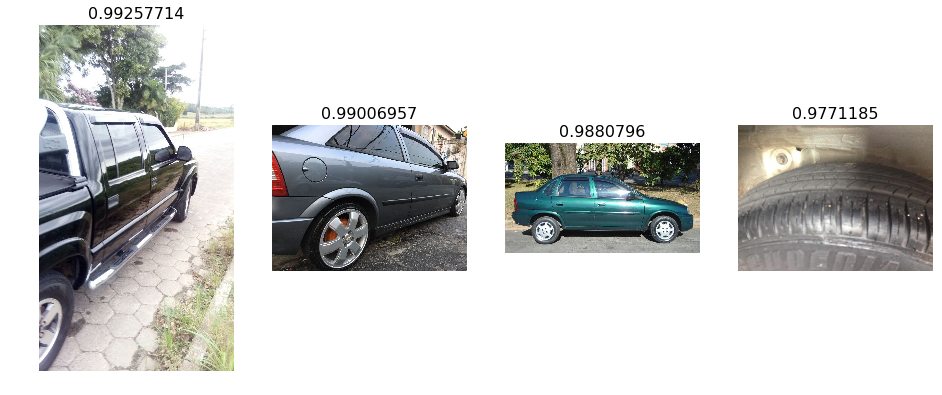

In [80]:
plot_val_with_title(most_by_correct(1, True), f"Most correct {data.classes[1]}")

Most incorrect pos_16


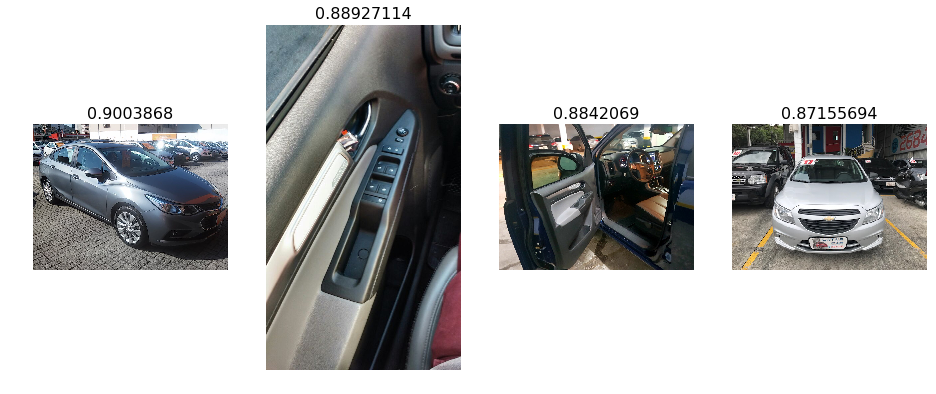

In [81]:
plot_val_with_title(most_by_correct(0, False), f"Most incorrect {data.classes[0]}")

Most incorrect pre_06


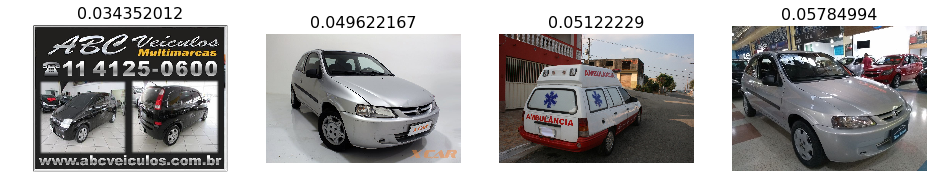

In [82]:
plot_val_with_title(most_by_correct(1, False), f"Most incorrect {data.classes[1]}")

Most uncertain predictions


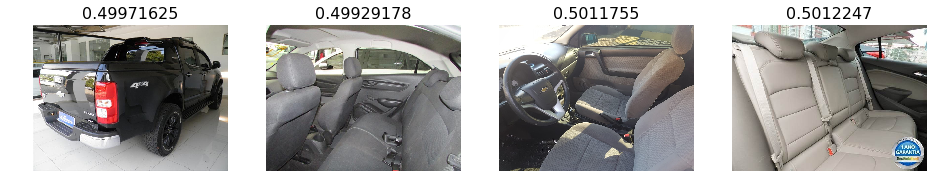

In [83]:
plot_val_with_title(most_uncertain, "Most uncertain predictions")


### Montagem do heat map

In [94]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn); 
    def hook_fn(self, module, input, output): self.features = output; print(output)
    def remove(self): self.hook.remove()

In [102]:
x,y = next(iter(data.val_dl))

In [103]:
i = np.random.randint(0,x.shape[1])
x,y = x[None,i], y[None,i]
vx = Variable(x.cpu(), requires_grad=True)

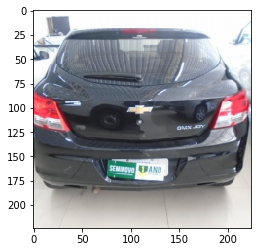

In [104]:
dx = data.val_ds.denorm(x)[0]
plt.imshow(dx);

In [105]:
sfs = [SaveFeatures(o) for o in [m[-7], m[-6], m[-5], m[-4]]]

In [106]:
%time py = m(Variable(x.cpu()))

Variable containing:
( 0 , 0 ,.,.) = 
  0.7321  0.4828  0.3683  ...   0.7554  0.5855  0.3571
  0.3504  0.3939  0.0000  ...   0.7292  2.1311  2.3012
  0.1411  0.1250  0.0613  ...   1.4525  3.1829  2.4065
           ...             ⋱             ...          
  0.7449  0.5080  0.6941  ...   0.0000  0.2051  0.4101
  0.4385  0.2763  0.7752  ...   0.1227  0.2857  0.5332
  0.2760  0.5472  0.3850  ...   0.1379  0.3404  0.5918

( 0 , 1 ,.,.) = 
  0.3734  0.2188  0.1772  ...   0.4198  0.3948  0.6487
  0.0383  0.2611  0.1431  ...   0.0460  0.0501  0.0737
  0.0885  0.2964  0.0750  ...   0.1239  0.0399  0.0611
           ...             ⋱             ...          
  0.0929  0.0092  0.0461  ...   0.0435  0.0641  0.1733
  0.0497  0.0318  0.0360  ...   0.0881  0.0830  0.2953
  0.1990  0.0650  0.0108  ...   0.1615  0.1256  0.2391

( 0 , 2 ,.,.) = 
  0.0000  0.0364  0.0000  ...   0.0000  0.0000  0.1755
  0.0000  0.1982  0.0000  ...   0.0000  0.0000  0.9284
  0.0000  0.0919  0.0000  ...   0.0000  0.0000

In [107]:
for o in sfs: o.remove()

In [108]:
[o.features.size() for o in sfs]

[torch.Size([1, 128, 28, 28]),
 torch.Size([1, 256, 14, 14]),
 torch.Size([1, 512, 7, 7]),
 torch.Size([1, 2, 7, 7])]

In [109]:
py = np.exp(to_np(py)[0]); py

array([1., 0.], dtype=float32)

In [110]:
feat = np.maximum(0,to_np(sfs[3].features[0]))
feat.shape

(2, 7, 7)

In [111]:
f2=np.dot(np.rollaxis(feat,0,3), py)
f2-=f2.min()
f2/=f2.max()
f2

array([[0.27957, 0.46513, 0.63151, 0.68998, 0.62577, 0.42355, 0.1716 ],
       [0.48087, 0.65123, 0.76165, 0.75788, 0.60173, 0.35776, 0.1253 ],
       [0.72732, 0.78603, 0.6369 , 0.40981, 0.24857, 0.09978, 0.     ],
       [0.9642 , 1.     , 0.68288, 0.35165, 0.3208 , 0.2848 , 0.13346],
       [0.9117 , 0.97201, 0.79135, 0.59647, 0.62428, 0.52833, 0.28306],
       [0.53324, 0.69384, 0.74561, 0.78314, 0.7935 , 0.60874, 0.26178],
       [0.10981, 0.22358, 0.31798, 0.38345, 0.40481, 0.28591, 0.09828]], dtype=float32)

/home/itsbarreto/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


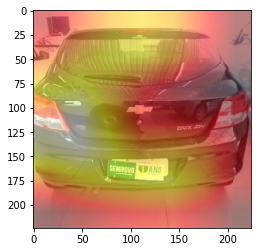

In [112]:
plt.imshow(dx)
plt.imshow(scipy.misc.imresize(f2, dx.shape), alpha=0.5, cmap='hot');